# Seq2Seq 기계 번역

- sequence를 입력으로 받아 sequence를 출력.
- 병렬 말뭉치(parallel corpora)라고 하는 원문-번역문 쌍이 필요.
- 막대한 리소스 필요.
- 각자 다른 역할을 하는 두 개의 RNN을 이어붙인 모델(인코더, 디코더)
- 인코더에서 원문 입력(동적인 시퀀스 데이터)를 문맥벡터(context vector, 간단한 형태의 정적인 데이터)로 요약하여 디코더로 전달하면, 디코더에선 그것과 문장시작 토큰을 사용하여 번역문을 출력한다.
- 보통 번역에는 워드 임베딩을 사용하지만, 간단한 영단어를 번역하는 작업엔 캐릭터 임베딩 사용.

이번 프로젝트에선 임의로 Seq2Seq 모델을 아주 간단화 시켰습니다.
한 언어로 된 문장을 다른 언어로 된 문장으로 번역하는 덩치가 큰 모델이 아닌
영어 알파벳 문자열("hello")을 스페인어 알파벳 문자열("hola")로 번역하는 Mini Seq2Seq 모델을 같이 구현해 보겠습니다.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [10]:
vocab_size = 256  # 총 아스키 코드 개수
x_ = list(map(ord, "hello"))  # 아스키 코드 리스트로 변환
y_ = list(map(ord, "hola"))   # 아스키 코드 리스트로 변환
print("hello -> ", x_)
print("hola  -> ", y_)

hello -&gt;  [104, 101, 108, 108, 111]
hola  -&gt;  [104, 111, 108, 97]


In [11]:
x = torch.LongTensor(x_) #파이토치 텐서로 변환
y = torch.LongTensor(y_)

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size) # 임베딩 함수 정의. hidden_size를 임베딩된 토큰의 차원값으로 정의.
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size) # 디코더가 다음 토큰을 예산해내는 작은 신경망을 하나 더 만듦.

    def forward(self, inputs, targets):
        # 인코더에 들어갈 입력(은닉 벡터)
        initial_state = self._init_state() 
        embedding = self.embedding(inputs).unsqueeze(1) # 인코더에 입력되는 원문을 구성하는 모든 문자를 임베딩시킨다.
        # embedding = [seq_len, batch_size, embedding_size]
        
        # 인코더 (Encoder)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        # encoder_output = [seq_len, batch_size, hidden_size]
        # encoder_state  = [n_layers, seq_len, hidden_size] : 문맥 벡터

        # 디코더에 들어갈 입력
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0]) # 문장 시작 토큰은 디코더가 정상적으로 작동할 수 있도록 인위적으로 넣은 토큰임. 실제로 문장에 나타나지는 않음. 아스키값으로 공백문자 null을 뜻하는 0으로 설정.
        
        # 디코더 (Decoder)
        outputs = []
        
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state) # 입력을 동시에 받음.
            projection = self.project(decoder_output) # 결과값으로 문자 출력. 결과값은 나중에 다시 디코더에 입력됨.
            outputs.append(projection) # 출력 저장
            
            # 풍부한 데이터를 바탕으로 학습하는 모델이라면 디코더의 예측값을 다음 반복에서 입력될 토큰으로 갱신해주는 것이 정석.
            # 학습이 아직 안된 상태의 모델은 잘못된 예측 토큰을 입력으로 사용할 확률이 높기 때문에 학습이 더뎌질수 있다.
            # 이를 방지하기 위해 티처 포싱(Teacher Forcing) 사용
            decoder_input = torch.LongTensor([targets[i]]) # 디코더 학습시 실제 번역문의 토큰을 디코더의 전 출력값 대신 입력으로 사용해 학습을 가속하는 방법. 번역문의 i번째 토큰에 해당하는 값 targets[i]를 디코더의 입력값으로 설정한다.

        outputs = torch.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [13]:
seq2seq = Seq2Seq(vocab_size, 16)

In [14]:
criterion = nn.CrossEntropyLoss() # 교차 엔트로피
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)

In [15]:
log = []
for i in range(1000): # epoch = 1000
    prediction = seq2seq(x, y)

    loss = criterion(prediction, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("\n 반복:%d 오차: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])


 반복:0 오차: 5.569903373718262
[&#39;À&#39;, &#39;À&#39;, &#39;í&#39;, &#39;\xa0&#39;]

 반복:100 오차: 1.9028899669647217
[&#39;h&#39;, &#39;o&#39;, &#39;a&#39;, &#39;a&#39;]

 반복:200 오차: 0.4795731008052826
[&#39;h&#39;, &#39;o&#39;, &#39;l&#39;, &#39;a&#39;]

 반복:300 오차: 0.2226085066795349
[&#39;h&#39;, &#39;o&#39;, &#39;l&#39;, &#39;a&#39;]

 반복:400 오차: 0.13702082633972168
[&#39;h&#39;, &#39;o&#39;, &#39;l&#39;, &#39;a&#39;]

 반복:500 오차: 0.09600420296192169
[&#39;h&#39;, &#39;o&#39;, &#39;l&#39;, &#39;a&#39;]

 반복:600 오차: 0.0721890926361084
[&#39;h&#39;, &#39;o&#39;, &#39;l&#39;, &#39;a&#39;]

 반복:700 오차: 0.05675509572029114
[&#39;h&#39;, &#39;o&#39;, &#39;l&#39;, &#39;a&#39;]

 반복:800 오차: 0.045994214713573456
[&#39;h&#39;, &#39;o&#39;, &#39;l&#39;, &#39;a&#39;]

 반복:900 오차: 0.038043275475502014
[&#39;h&#39;, &#39;o&#39;, &#39;l&#39;, &#39;a&#39;]


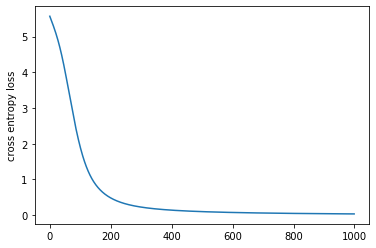

In [16]:
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()